In [67]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import os
from functools import reduce
from statsmodels.tsa.stattools import coint
from sklearn import mixture as mix
from pykalman import KalmanFilter
import statsmodels.api as sm
import ffn

sns.set(style='white')
# Retrieve intraday price data and combine them into a DataFrame.
# 1. Load downloaded prices from folder into a list of dataframes.
folder_path = 'STATICS/PRICE'
file_names  = ['ryaay.csv','rya.csv']
tickers     = [name.split('.')[0] for name in file_names]
df_list     = [pd.read_csv(os.path.join('STATICS/PRICE', name)) for name in file_names]

In [69]:
# 2. Replace the closing price column name by the ticker.
for i in range(len(df_list)):
    df_list[i].rename(columns={'close': tickers[i]}, inplace=True)

# 3. Merge all price dataframes
df  = reduce(lambda x, y: pd.merge(x, y, on='date'), df_list)

df.set_index('date',inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,ryaay,rya
date,,
2018-07-25 13:37:00,105.180,16.497130
2018-07-25 13:38:00,105.175,16.496848
2018-07-25 13:39:00,105.270,16.509245
2018-07-25 13:40:00,105.260,16.510092
2018-07-25 13:41:00,106.750,16.515515


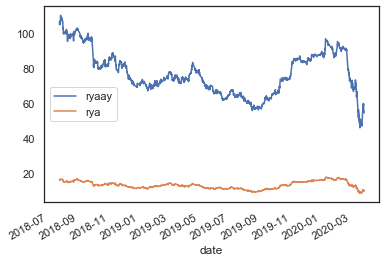

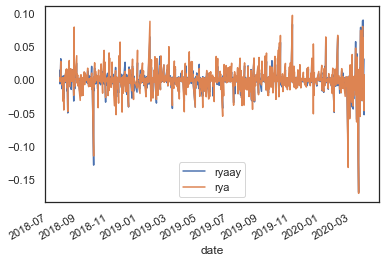

In [70]:
df.describe()
df.plot()
returns =  df.pct_change()
returns.plot()


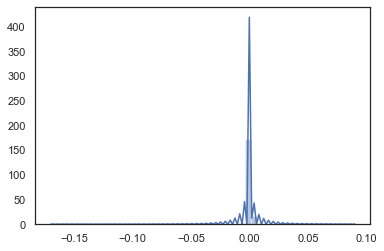

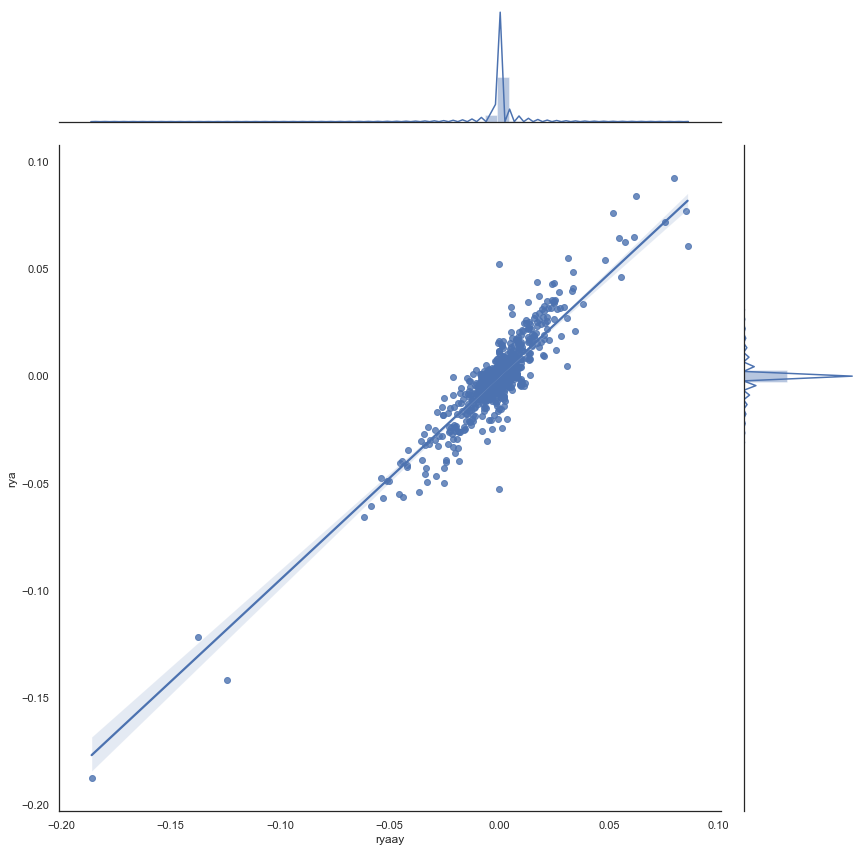

In [72]:
sns.distplot(returns.iloc[:,0:1])

log_ret_RYAAY = np.log(df['ryaay']) - np.log(df['ryaay'].shift(1)) 
log_ret_RYA = np.log(df['rya']) - np.log(df['rya'].shift(1))

#Plot using Seaborn's jointplot function
sns.jointplot(log_ret_RYAAY, log_ret_RYA, kind='reg', size=12)

In [73]:
score, pvalue, _ = coint(df['ryaay'],df['rya'])
print(pvalue)
print(df['ryaay'].corr(df['rya']))

0.21067535847732943
0.9366931273251048


In [32]:
kf = KalmanFilter(transition_matrices = [1],
     observation_matrices = [1],
     initial_state_mean = 0,
     initial_state_covariance = 1,
     observation_covariance=1,
     transition_covariance=.01)

In [34]:
x_state_means, _ = kf.filter(df['rya'].values)
y_state_means, _ = kf.filter(df['ryaay'].values)



    state_means = pd.Series(state_means.flatten(), index=x.index)

(array([[ 8.26782323],
        [11.05993241],
        [12.47211655],
        ...,
        [10.13203485],
        [10.12688496],
        [10.12297751]]),
 array([[[0.5       ]],
 
        [[0.33774834]],
 
        [[0.25802172]],
 
        ...,
 
        [[0.09512492]],
 
        [[0.09512492]],
 
        [[0.09512492]]]))

In [8]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
  
    kf = KalmanFilter(transition_matrices = [1],
     observation_matrices = [1],
     initial_state_mean = 0,
     initial_state_covariance = 1,
     observation_covariance=1,
     transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
     initial_state_mean=[0,0],
     initial_state_covariance=np.ones((2, 2)),
     transition_matrices=np.eye(2),
     observation_matrices=obs_mat,
     observation_covariance=2,
     transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

In [164]:
def backtest(s1, s2, x, y):
    #############################################################
    # INPUT:
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two
    # OUTPUT:
    # Trade records
    # run regression to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    
    df1['hr'] = - state_means[:,0]
    #Round to 2
    df1['hr'] = df1['hr'].round(2)
    df1['spread'] = df1.y + (df1.x * df1.hr)
    
    # calculate half life
    halflife = half_life(df1['spread'])
    # calculate z-score with window = half life period
    
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = ((df1.spread-meanSpread)/stdSpread).shift(1)
    
    ##############################################################
    # trading logic
    entryZscore = 2
    exitZscore = 0
    
    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad') #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    
    # Boolean whether transaction occurred
    df1['transaction'] = df1.numUnits.shift(1) != df1.numUnits
    
    df1['positionSwitch'] = (df1.numUnits.shift(1) == (-df1.numUnits)) & df1['transaction']
    
    # Cost of transaction
    df1['tradecosts'] = (df1['transaction'] *1 + df1['positionSwitch']*1 ) * 0.0063 
    
    # Save hr during holding period
    df1['hr_memory'] = np.nan
    df1['hr_memory'][df1['transaction'] & df1['numUnits'] != 0] = df1.hr[df1['transaction'] & df1['numUnits'] != 0]
    df1['hr_memory'].fillna(method='ffill',inplace=True)
    
    # Save investment amount during holding period
    df1['invest_memory'] = np.nan
    df1['invest_memory'][df1['transaction'] & df1['numUnits'] != 0] = \
                            ((df1['x'] * abs(df1['hr'])) + df1['y'])[df1['transaction'] & df1['numUnits'] != 0]
    df1['invest_memory'].fillna(method='ffill',inplace=True)
    
    # Save spread according to hr_memory
    df1['spreadmemory'] = df1.y + (df1.x * df1.hr_memory)
    
    # Calculate spread percent change
    df1['spread pct ch'] = (df1['spreadmemory'] - df1['spreadmemory'].shift(1)) / df1['invest_memory']
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1) - (df1['tradecosts'] /df1['invest_memory'])

    # Account for the position switch
    df1['port rets'][df1['positionSwitch']] = (((df1.y + (df1.x * df1.hr_memory.shift(1))\
                                - df1['spreadmemory'].shift(1)) / df1['invest_memory'].shift(1))\
                                * df1['numUnits'].shift(1) - (df1['tradecosts'] /df1['invest_memory'].shift(1)))\
                                [df1['positionSwitch']]


    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    #name = "bt"+ s1 + "-" + s2 + ".csv"
    #df1.to_csv(name)

    return df1,halflife

In [165]:
import warnings
warnings.filterwarnings('ignore')

out,halflife = backtest('rya','ryaay',df['rya'],df['ryaay'])
# Filter outliers, create a lag or resample to 5 minutes

date
2018-07-25 13:37:00    1.0
2018-07-25 13:38:00    1.0
2018-07-25 13:39:00    1.0
2018-07-25 13:40:00    1.0
2018-07-25 13:41:00    1.0
Name: cum rets, dtype: float64

In [152]:

perf =out['cum rets'].calc_stats()
perf.set_riskfree_rate(0.0016)
perf.display()

Stats for cum rets from 2018-07-25 13:37:00 - 2020-03-27 15:55:00
Annual risk-free rate considered: 0.16%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
14.00%              2.15  8.15%   -2.27%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y     5y    10y    incep.
-----  -----  -----  -----  -----  -----  ----  -----  --------
2.04%  1.74%  1.05%  1.74%  3.49%  8.15%  -     -      8.15%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  2.15     2.04       1.62
mean    8.14%    8.11%      2.96%
vol     3.71%    3.89%      1.72%
skew    1.14     0.36       -
kurt    10.36    -1.05      -
best    1.71%    2.65%      4.17%
worst   -1.18%   -0.85%     1.74%

Drawdowns:
max     avg       # days
------  ------  --------
-2.27%  -0.42%     18.46

Misc:
---------------  -------
avg. up month    1.21%
avg. down month  -0.58%
up year %        100.00%
12m up %         100.00%
------------

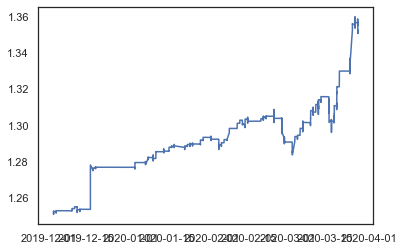

In [139]:
#plt.plot(out["2018-10-24":"2018-10-24"]['cum rets'])
plt.plot(out["2019-12-01":"2020-12-01"]['cum rets'])

In [128]:
def plot_signals(d, fromDate, toDate):
    
    #idx = pd.date_range(fromDate,toDate, freq="1min")

    d = d[fromDate:toDate]
    #d = d.reindex(idx, fill_value= np.nan)
    d.index = d.index.map(str)
    # Plot the prices and buy and sell signals from z score
    
    
    S = d.y - d.x * 5

    S.plot(color='b')
    
    buyS = 0*S.copy()
    sellS = 0*S.copy()
    exitL = 0*S.copy()
    exitS = 0*S.copy()
    
    longentry = d['long entry'] * d.transaction * (d.numUnits == 1)
    longexit = d['long exit'] * d.transaction * (d.numUnits.shift(1) == 1)
    shortentry = d['short entry'] * d.transaction * (d.numUnits == -1)
    shortexit = d['short exit'] * d.transaction * (d.numUnits.shift(1) == -1)
    
    buyS[longentry] = S[longentry]
    sellS[shortentry] = S[shortentry]
    exitL[longexit] = S[longexit]
    exitS[shortexit] = S[shortexit]
    
    buyS.plot(color='g', linestyle='None', marker='o')
    sellS.plot(color='r', linestyle='None', marker='o')
    exitL.plot(color='g', linestyle='None', marker='x')
    exitS.plot(color='r', linestyle='None', marker='x')
    
    x1,x2,y1,y2 = plt.axis()

    plt.axis((x1,x2,S.min(),S.max()))

    plt.legend(['LOP Spread', 'Enter Long', 'Enter Short','Exit Long', 'Exit Short'])
    plt.xticks(rotation=45, ha="right")
    
    plt.show()
    
    
    
    print('{} percent return in time window'.format(round(d['port rets'].sum() *100,2)))
    

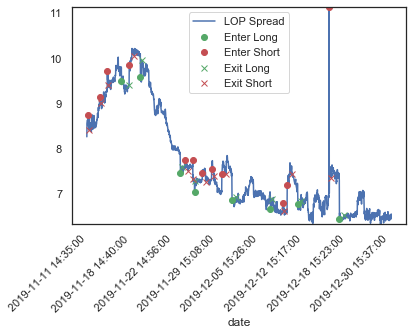

3.7 percent return in time window


(array([737378., 737385., 737394., 737401., 737408., 737415., 737425.]),
 <a list of 7 Text xticklabel objects>)

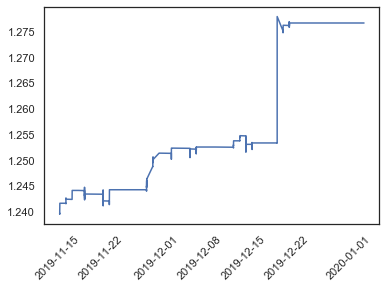

In [149]:
plot_signals(out,"2019-11-10","2019-12-30")

plt.plot(out["2019-11-10":"2019-12-30"]['cum rets'])
plt.xticks(rotation=45, ha="right")

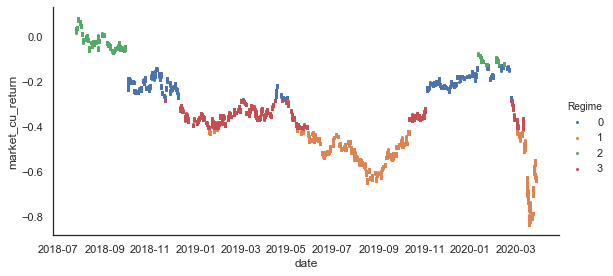

In [131]:
#Get spread
S = out.y - out.x * out.hr

#Fit gaussian
unsup = mix.GaussianMixture(n_components=4, 
                            covariance_type="spherical", 
                            n_init=100, 
                            random_state=42)
unsup.fit(S.values.reshape(-1, 1))
# Predict
regime = unsup.predict(S.values.reshape(-1, 1))

S = S.to_frame()
S['Return']= np.log(S/S.shift(1))

Regimes=pd.DataFrame(regime,columns=['Regime'],index=S.index).join(S, how='inner')\
                          .assign(market_cu_return=S.Return.cumsum())\
                                 .reset_index(drop=False)\
                                             .rename(columns={'index':'date'})
                     

fig = sns.FacetGrid(data=Regimes,hue='Regime',hue_order=[0,1,2,3],aspect=2,size= 4)
fig.map(plt.scatter,'date','market_cu_return', s=4).add_legend()
plt.show()


In [17]:
for i in [0,1,2,3]:
    print('Mean for regime %i: '%i,unsup.means_[i][0])
    print('Co-Variancefor regime %i: '%i,(unsup.covariances_[i]))

Mean for regime 0:  160.03792012269997
Co-Variancefor regime 0:  49.13292797451834
Mean for regime 1:  117.53124259865577
Co-Variancefor regime 1:  137.6761483285078
Mean for regime 2:  137.83250068764195
Co-Variancefor regime 2:  19.588828893767303
Mean for regime 3:  190.43690033596855
Co-Variancefor regime 3:  75.24252765245149
